In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import subprocess
import numpy as np

In [2]:
# Specify ECOLI or PSIMIAE
DAP_SPECIES = "PSIMIAE"
#DAP_SPECIES = "ECOLI"

# Define paths to input files, and read them

In [3]:
data_path     = "/global/homes/v/vsevim/scratch/ML/grammar/data/"
multidap_path = data_path + "orthos/multidap/"
tf_names_file_path  = data_path + f"TF_Nos_{DAP_SPECIES}.TXT"
index_file_path     = data_path + "index_to_species.tsv"

df_tf               = pd.read_csv(tf_names_file_path, names=['tf_no'], dtype={'tf_no':str})
df_dap_index        = pd.read_csv(index_file_path, sep='\t', names=['tag', 'species'])
dap_index_to_genome = df_dap_index.set_index('tag')['species'].to_dict()

# Some gff annotations are missing. List which ones.

In [4]:
import subprocess
PATH_TO_SCRIPTS="/global/homes/v/vsevim/scratch/ML/grammar/nb/"
PATH_TO_REFS="/global/homes/v/vsevim/scratch/ML/grammar/data/refs/"

print(".gff files for these species are not found:")

# Loop over all species
for species in df_dap_index.species.values:
    path = f"{PATH_TO_REFS}/{species}/{species}.gff"
    cmd = f"cat {path} | grep -v \"^#\" | head -n1 | cut -f1"
    #print(cmd)
    output = subprocess.check_output(cmd, shell=True)
    output = output.decode().strip("\n")
    
    if output == "":
        print(" ", species)
        #! ls {PATH_TO_REFS}/{species}
        #print("---\n")

.gff files for these species are not found:
  Enterococcus_faecalis_OG1RF-ATCC47077
  Clostridium_difficile_DSM1296
  Corynebacterium_glutamicum_ATCC13032
  Staphylococcus_aureus_ATCC25923
  Yokenella_regensburgei_ATCC43003
  Hafnia_alvei_ATCC51873


# For each TF, extract sequences of top 10 summits from each genome

Write them under `summit_seqs/TF/SPECIES.fa`. Concatenate all into `TF_SUMMIT_SEQS_ALL_GENOMES.TSV`

In [5]:
for i, tf_no in enumerate(df_tf.tf_no.values):
    glob_filter = multidap_path + tf_no + "_?-*????????+????????/*summits_blist_top10.narrow*"
    summit_file_paths =  glob(glob_filter)

    if not summit_file_paths:
        print("skipping", tf_no, summit_file_paths)
        continue  
        
    outpath = f"{data_path}/summit_seqs/{DAP_SPECIES}/{tf_no}/"    
    !mkdir -p {outpath}
    !rm -rf {outpath}/*
        
    for summit_path in summit_file_paths:
        summit_file_name    = summit_path.split("/")[-1]
        target_dap_index  = summit_file_name.split('+')[1].split("_")[0]
        genome_name = dap_index_to_genome[target_dap_index]
        genome_fasta_path = f"{data_path}/refs/{genome_name}/{genome_name}.fasta"  
        
        outfile_name = f"{outpath}/{genome_name}_summit_seqs.fa"
        joined_outfile_name = f"{outpath}/{genome_name}_summit_seqs.tsv"
        !bedtools getfasta -fi {genome_fasta_path} -bed {summit_path} > {outfile_name} 
    
    ! cat {outpath}/*_summit_seqs.fa > {outpath}/{tf_no}"_SUMMIT_SEQS_ALL_GENOMES.fa"
    print(f"TF {tf_no} complete.")
print("All done.")

TF accB complete.
TF acrR complete.
TF ada complete.
TF adiY complete.
TF agaR complete.
TF aidB complete.
TF alaS complete.
TF allR complete.
TF allS complete.
TF alpA complete.
TF alsR complete.
TF appY complete.
TF araC complete.
TF arcA complete.
TF argP complete.
TF argR complete.
TF arsR complete.
TF ascG complete.
TF asnC complete.
TF atoC complete.
TF baeR complete.
TF basR complete.
TF betI complete.
TF bglJ complete.
TF birA complete.
TF bluR complete.
TF bolA complete.
TF btsR complete.
TF cadC complete.
TF caiF complete.
TF cbl complete.
TF cdaR complete.
TF cecR complete.
TF chbR complete.
TF comR complete.
TF cpxR complete.
TF cra complete.
TF creB complete.
TF crp complete.
TF csgD complete.
TF csiR complete.
TF cspA complete.
TF ctl complete.
TF cueR complete.
TF cusR complete.
TF cynR complete.
TF cysB complete.
TF cytR complete.
TF dcuR complete.
TF decR complete.
TF deoR complete.
TF dhaR complete.
TF dicA complete.
TF dinJ complete.
TF dnaA complete.
TF dpiA complet

# RUN STARTING HERE ####

## Import the hits+closest genes

In [6]:
def find_gene_name(bed_annotation):
    split_ann = bed_annotation.split(";")
    name = [f for f in split_ann if f.startswith("gene=")]
    if len(name) > 1:
        print("multiple gene names in annotation!")
        return 0
    else:
        return name[0].replace("gene=", "")

In [7]:
#df_grouped = df.groupby(by=["start", "end", "strand"])

In [8]:
# cols_to_pick = ["acc", "start", "end", "score", "strand",  "bed_acc", "feature_type", "gene_start", "gene_end", "gene_orientation", "gene_name"]

# for group_name, df_group in df_grouped:
#     df_group = df_group.sort_values(by='gene_start')
#     if len(df_group) != 2:
#         print("non-2")
#         break
#     else:
#         indexes = df_group.index.values
#         break
#         #df_group.loc[indexes[0], cols_to_pick]


In [9]:
# print(df_group.loc[indexes[0],cols_to_pick].values)
# print(df_group.loc[indexes[1],cols_to_pick].values)

# Extract intergenic regions, find upstream and downstream genes

In [10]:
%%bash
set -e
module load samtools
blue=$(tput setaf 4)
red=$(tput setaf 1)
normal=$(tput sgr0)

PATH_TO_SCRIPTS="/global/homes/v/vsevim/scratch/ML/grammar/nb/"
PATH_TO_REFS="/global/homes/v/vsevim/scratch/ML/grammar/data/refs/"

while read -r SPECIES; do
    REF_PATH="$PATH_TO_REFS/$SPECIES/"
    REF_GFF="$SPECIES.gff"
    REF_FASTA="$SPECIES.fasta"
    REF_SORTED_GFF="$SPECIES.sorted.gff"
    UNSORTED_REF_INDEX="$SPECIES.fasta.fai"
    REF_INDEX="$SPECIES.sorted.fasta.fai"
    FILTERED_GFF_FILE="$SPECIES""_filt.gff"
    SORTED_GENES_GFF="filtered_annotations.sorted.gff"
    INTERGENICS_BED="intergenics.bed"
    INTERGENIC_NAME_SEPERATOR=":"

    # Sort the ref
    cd "$REF_PATH" 

    if [[ ! -f "$REF_GFF" ]]; then
        printf  "${red}$SPECIES skipping...${normal}\n"
        continue
    fi
    
    printf "${blue} * $SPECIES * ${normal}: "
    echo "Sorting $REF_GFF"
    bedtools sort -i "$REF_GFF" > "$REF_SORTED_GFF"

    echo "Indexing..."
    samtools faidx "$REF_FASTA" 

    echo "Sorting $UNSORTED_REF_INDEX"
    sort -k1,1 "$UNSORTED_REF_INDEX" > "$REF_INDEX"

    # Sort the reference and the motif hits
    echo "Sorting $FILTERED_GFF_FILE into $SORTED_GENES_GFF"
    bedtools sort -i "$FILTERED_GFF_FILE" > "$SORTED_GENES_GFF"
    
    # Get intergenic regions
    echo "Getting intergenic regions, writing into dummy.bed"
    echo "bedtools complement -i $SORTED_GENES_GFF -g $REF_INDEX > dummy.bed"
    bedtools complement \
        -i "$SORTED_GENES_GFF" \
        -g "$REF_INDEX" |
        awk -v sep="$INTERGENIC_NAME_SEPERATOR" \
            '{printf "%s\t%s%s%05d\n",$0,$1,sep,i++; }' > \
            "dummy.bed"

    echo "Sorting intergenic regions, writing into $INTERGENICS_BED"
    bedtools sort -i dummy.bed > "$INTERGENICS_BED"
    num_intergenic_seqs=`wc -l "$INTERGENICS_BED"`
    echo "#intergenic regions=$num_intergenic_seqs"

    # Find the upstream gene of each intergenic region
    echo "Finding upstream genes of each intergenic seq, writing into dummy.bed..."
    bedtools closest \
        -D ref -fu -t first \
        -a "$INTERGENICS_BED" \
        -b "$SORTED_GENES_GFF" |\
            cut -f 1-4,7-9,11,13 > "dummy.bed" 
    
    echo "Extracting gene names from the output..."
    awk -f "$PATH_TO_SCRIPTS/filter_closest_bed_2.awk" \
        "dummy.bed" > "dummy2.bed"
    
    echo "Sorting, writing into upstreams.bed..."
    bedtools sort -i "dummy2.bed" > "upstreams.bed"

    # Find the downstream gene of each intergenic region
    echo "Finding upstream genes of each intergenic seq, writing into dummy.bed..."
    bedtools closest \
        -D ref -fd -t first \
        -a "$INTERGENICS_BED" \
        -b "$SORTED_GENES_GFF" |\
            cut -f 1-4,7-9,11,13 > "dummy.bed"
    

    echo "Extracting gene names from the output..."
    awk -f "$PATH_TO_SCRIPTS/filter_closest_bed_2.awk" \
        "dummy.bed" > "dummy2.bed"
    
    echo "Sorting, writing into downstreams.bed..."
    bedtools sort -i "dummy2.bed" > "downstreams.bed"

    echo "Merging, creating intergenics_and_neighbors.bed"
    paste "upstreams.bed" "downstreams.bed" | \
        cut -f1-10,15-20 > \
        "intergenics_annotated.bed"

    rm dummy*
    printf "*******\n"
done < "species_order.txt"
echo "Completed."

 * Escherichia_coli_MG1655 * : Sorting Escherichia_coli_MG1655.gff
Indexing...
Sorting Escherichia_coli_MG1655.fasta.fai
Sorting Escherichia_coli_MG1655_filt.gff into filtered_annotations.sorted.gff
Getting intergenic regions, writing into dummy.bed
bedtools complement -i filtered_annotations.sorted.gff -g Escherichia_coli_MG1655.sorted.fasta.fai > dummy.bed
Sorting intergenic regions, writing into intergenics.bed
#intergenic regions=3721 intergenics.bed
Finding upstream genes of each intergenic seq, writing into dummy.bed...
Extracting gene names from the output...
Sorting, writing into upstreams.bed...
Finding upstream genes of each intergenic seq, writing into dummy.bed...
Extracting gene names from the output...
Sorting, writing into downstreams.bed...
Merging, creating intergenics_and_neighbors.bed
*******
 * Escherichia_coli_BW25113 * : Sorting Escherichia_coli_BW25113.gff
Indexing...
Sorting Escherichia_coli_BW25113.fasta.fai
Sorting Escherichia_coli_BW25113_filt.gff into filter

***** WARNING: NC_009792.1:4719698-4721231 exceeds the length of chromosome (NC_009792.1)
***** WARNING: NC_009793.1:8992-9370 exceeds the length of chromosome (NC_009793.1)
***** WARNING: NC_009652.1:4041-4266 exceeds the length of chromosome (NC_009652.1)
***** WARNING: NZ_CP008919.1:45755-53104 exceeds the length of chromosome (NZ_CP008919.1)
***** WARNING: NZ_CP008920.1:4285352-4285991 exceeds the length of chromosome (NZ_CP008920.1)
***** WARNING: NC_008573.1:278591-279842 exceeds the length of chromosome (NC_008573.1)
***** WARNING: NZ_CP012831.1:7118733-7119507 exceeds the length of chromosome (NZ_CP012831.1)
***** WARNING: NZ_CP015511.1:3263774-3265526 exceeds the length of chromosome (NZ_CP015511.1)
***** WARNING: NZ_CP022260.1:924965-925385 exceeds the length of chromosome (NZ_CP022260.1)
***** WARNING: NZ_CP022261.1:196705-198172 exceeds the length of chromosome (NZ_CP022261.1)
***** WARNING: NZ_CP021236.1:203268-205941 exceeds the length of chromosome (NZ_CP021236.1)


# Scan all summits for motif occurrences

...then annotate them by intersecting with the intergenics bed file.

In [11]:
def count_lines_in_file(f_name):
    return sum(1 for line in open(f_name))

In [12]:
%%capture cap 
from termcolor import colored
import sys
import pandas as pd

FIMO                = "~/software/meme/bin/fimo"
MAIN_PATH           = "/global/homes/v/vsevim/scratch/ML/grammar/"
DATA_PATH           = MAIN_PATH + "data/"
MOTIF_PATH          = DATA_PATH + "48sp01_selected_motifs/"
PATH_TO_SCRIPTS     = DATA_PATH + "/nb/"
PATH_TO_REFS        = DATA_PATH + "/refs/"
PATH_TO_SUMMIT_SEQS = DATA_PATH + f"/summit_seqs/{DAP_SPECIES}"

# Loop over all TFs
for i, tf_no in enumerate(df_tf.tf_no.values):
    tf_path = f"{PATH_TO_SUMMIT_SEQS}/{tf_no}"
    motif_file = f"{MOTIF_PATH}{tf_no}.txt"
    
    if not os.path.isdir(tf_path):
        message = colored(f"TF {tf_no} not found. Skipping.", 'red')
        print(message)
        print("*", tf_path, "*")
        continue
    
    message = colored(f"\n ** TF {tf_no}", 'blue')
    print(message)
        
    if not os.path.isfile(motif_file):
        message = colored(f"Motif file not found. Skipping.", 'red')
        print(message)
        print("*", motif_file, "*")
        continue
    
    # Loop over all species
    for species in df_dap_index.species.values:
        fimo_dir = f"{tf_path}/fimo_{species}/"
        exit_code = os.system(f"mkdir -p {fimo_dir}")

        if exit_code:
            message = colored(f"\n Err {exit_code}. Can't create {fimo_dir}! Exiting", 'red')
            print(message)
            sys.exit()
        
        summit_seqs_file  = f"{species}_summit_seqs.fa"
        summit_seqs_path  = f"{tf_path}/{summit_seqs_file}"
        fimo_stdout = f"{fimo_dir}stdout.txt"
        fimo_stderr = f"{fimo_dir}stderr.txt"

        if not os.path.isfile(summit_seqs_path):
            message = colored(f"{summit_seqs_file} file not found. Skipping.", 'red')
            print(message)
            continue
        
        print(f"Running fimo on {summit_seqs_file}...", end="")       
        fimo_command = f"{FIMO} --parse-genomic-coord -oc {fimo_dir} "\
                       f"{motif_file} {summit_seqs_path} >{fimo_stdout} 2>{fimo_stderr}"      
        exit_code = os.system(fimo_command)
        
        if not exit_code:  
            print("Fimo completed.")
        else:
            message = colored(f"\nFimo returned {_exit_code}!", 'red')
            print(message)
        
        # Sort fimo output
        fimo_file_path = f"{fimo_dir}/fimo.gff"
        fimo_sorted_file_path = f"{fimo_dir}/fimo.sorted.gff"
        fimo_annotated_file_path = f"{fimo_dir}/fimo.annotated.bed"
        intergenics_file_path = f"{PATH_TO_REFS}/{species}/intergenics_annotated.bed"
        sort_command = f"bedtools sort -i {fimo_file_path} > {fimo_sorted_file_path}"
        os.system(sort_command)
        
        # Annotate fimo hits
        print("Annotating fimo hits... ", end="")
        print(fimo_annotated_file_path)
        command =  f"bedtools intersect"\
                   f" -wa -wb"\
                   f" -a {fimo_sorted_file_path}"\
                   f" -b {intergenics_file_path}"\
                   f"> {fimo_annotated_file_path}"

        exit_code = os.system(command)
        if exit_code:  
            message = colored(f"\nbedtools intersect returned {_exit_code}!", 'red')
            print(message)
     
        # Append a new column filled with the TF id.
        if os.path.isfile(fimo_annotated_file_path) and\
           os.path.getsize(fimo_annotated_file_path) > 0:
            dummy_tsv_name = f"{fimo_dir}/dummy.tsv" 
            dummy_df = pd.read_csv(fimo_annotated_file_path, sep="\t", header=None)
            dummy_df['tf_id'] = tf_no
            dummy_df['species'] = species
            dummy_df.to_csv(dummy_tsv_name, sep="\t", header=None, index=False)
            os.system(f"mv {dummy_tsv_name} {fimo_annotated_file_path}")
        
        
        num_fimo_hits = count_lines_in_file(fimo_file_path) 
        num_annotated_fimo_hits = count_lines_in_file(fimo_annotated_file_path)
        diff = num_fimo_hits - num_annotated_fimo_hits
        message = colored(f"{num_fimo_hits} - {num_annotated_fimo_hits} = {diff}", 'green')
        print("all_fimo_hits - intergenic_hits: ", end="")
        print(message)
        
    print(f"TF {tf_no} completed.")

#     if i>4:
#         break

print("All completed.")

Print and save the output

In [13]:
#print(cap)
dummy_path = f"{DATA_PATH}/output_fimo_scan_all_{DAP_SPECIES}.txt"
print(dummy_path)

with open(dummy_path, 'w+') as f:
    f.write(cap.stdout)

/global/homes/v/vsevim/scratch/ML/grammar/data//output_fimo_scan_all_ECOLI.txt


# Build a df out of annotated motif hits: RERUN FROM HERE

## Read all annotated motif hits into a df

First concatenate all annotated fimo outputs (motif occurrences)

In [4]:
import pandas as pd

In [5]:
MAIN_PATH = "/global/homes/v/vsevim/scratch/ML/grammar/"
PATH_TO_SUMMIT_SEQS = MAIN_PATH + f"data/summit_seqs/{DAP_SPECIES}/"
all_annotated_hits_wildcard  = f"{PATH_TO_SUMMIT_SEQS}/*/fimo_*/fimo.annotated.bed"
all_annotated_fimo_hits_path = f"{MAIN_PATH}/data/{DAP_SPECIES}_RESULTS/ALL_FIMO_HITS_ANNOTATED.bed"
fimo_df_path                 = f"{MAIN_PATH}/data/{DAP_SPECIES}_RESULTS/ALL_FIMO_HITS_ANNOTATED.pkl"
fimo_hits_to_ortos_bed_path  = f"{MAIN_PATH}/data/{DAP_SPECIES}_RESULTS/VALID_FIMO_HITS.bed"

In [6]:
! cat {all_annotated_hits_wildcard} | cut --complement -f2,3 > {all_annotated_fimo_hits_path} 

In [7]:
! bedtools sort -i {all_annotated_fimo_hits_path} > "dummy_sort.bed"

In [8]:
! mv "dummy_sort.bed" {all_annotated_fimo_hits_path}

In [9]:
# u: upstream, d: downstream; ori: orientation

names = ("chr", "start", "end", "score", "strand", "x", "anno",\
         "intergenic_chr", "intergenic_start", "intergenic_end", "intergenic_label",\
         "u_type", "u_start", "u_end", "u_ori", "u_accession", "u_name",\
         "dw_type", "d_start", "d_end", "d_ori", "d_accession", "d_name", "tf_id", "species")

df_fimo = pd.read_csv(all_annotated_fimo_hits_path, sep="\t", names=names)

# Add a genome accession column
# all_chr = df_fimo['chr'].values
# accessions = [x.split(".")[0] for x in all_chr]
# df_fimo['genome_accession'] = accessions

# Save fimo df
df_fimo.to_pickle(fimo_df_path)

In [10]:
df_fimo.head(2)

chr  start   end  score strand  x  \
0  CP001978.1   2823  2842   43.3      +  .   
1  CP001978.1   5600  5621   59.2      +  .   

                                                anno intergenic_chr  \
0  Name=Ps338_CP001978.1+;Alias=MEME-1;ID=Ps338-M...     CP001978.1   
1  Name=Ps23_CP001978.1+;Alias=MEME-1;ID=Ps23-MEM...     CP001978.1   

   intergenic_start  intergenic_end  ... u_accession u_name  dw_type  d_start  \
0              2674            3098  ...  ADP95767.1   _na_      CDS     3099   
1              5353            5653  ...  ADP95769.1   atoB      CDS     5654   

  d_end d_ori d_accession d_name  tf_id                      species  
0  4025     -  ADP95768.1   _na_    338  Marinobacter_adhaerens_HP15  
1  6310     -  ADP95770.1   _na_     23  Marinobacter_adhaerens_HP15  

[2 rows x 25 columns]

In [11]:
len(df_fimo)

16046

## Check validity of P.simiae TF targets in other species using orthology info. Add those to fimo df. 

In [12]:
def add_accessions_as_index(df):
    from Bio import SeqIO
    accessions = [" "]*len(df.index)

    for i, species in enumerate(df.index):
        #! head -n1 {MAIN_PATH}/data/refs/{species}/{species}.fasta | cut -f1 -d " "
        fasta_name = f"{MAIN_PATH}/data/refs/{species}/{species}.fasta"
        first_record = next(SeqIO.parse(fasta_name, "fasta"))
        id = first_record.id.split(".")[0]

        accessions[i] = id

    df['species_name'] = df.index.values     
    df['accession'] = accessions    
    df.set_index('accession', inplace=True, verify_integrity=True)

    return df

Load the orthology file. Leo's file has species names for indices. Change those to accessions.

In [13]:
import os
MAIN_PATH = "/global/homes/v/vsevim/scratch/ML/grammar/"
leos_ortho_file = f"{MAIN_PATH}/data/orthos/multidap_orthogroup_overlap_pairs_no_operons.pkl"
df_ortho = pd.read_pickle(leos_ortho_file)

Add a new column to fimo df to specify the target gene. target: upstream, downstream, both (categorical) 

In [14]:
target_selection = {'++':'downstream', '--':'upstream', '+-':'neither', '-+':'both'}
upstream_orientation   = df_fimo['u_ori'].values
downstream_orientation = df_fimo['d_ori'].values
orientations = [ p[0]+p[1] for p in zip(upstream_orientation, downstream_orientation)] 

target_location = [ target_selection[pair] for pair in orientations ]
df_fimo['target_location'] = pd.Categorical(target_location)

In [15]:
df_fimo.head(1)

chr  start   end  score strand  x  \
0  CP001978.1   2823  2842   43.3      +  .   

                                                anno intergenic_chr  \
0  Name=Ps338_CP001978.1+;Alias=MEME-1;ID=Ps338-M...     CP001978.1   

   intergenic_start  intergenic_end  ... u_name dw_type  d_start  d_end d_ori  \
0              2674            3098  ...   _na_     CDS     3099   4025     -   

  d_accession d_name tf_id                      species  target_location  
0  ADP95768.1   _na_   338  Marinobacter_adhaerens_HP15         upstream  

[1 rows x 26 columns]

Check if upstream and downstream genes for each motif occurrence are in the list of orthologs 

In [16]:
def is_ortho(df_ortho, target_species, tf_id, target_gene_acc):
    # Each entry in df_ortho contains a list.
    # Each element in the list is a tuple w/ three elements (triplet)
    # (anchor_species_cds_id, anchor_species_gene_acc), (target_species_cds_id, target_species_gene_acc), orthogroup_id 
    
    # Get all triplets  
    triplets = df_ortho.loc[target_species][tf_id]

    if type(triplets) != list:
        return False
    
    # Get target species orthologous gene accessions
    list_of_orthos = [x[1][1] for x in triplets]
        
    if target_gene_acc in list_of_orthos:
        return True
    else:
        return False

Determine if the *target* gene for the binding site (upstr or downstr) has a P.Simiae ortholog 

In [17]:
def is_target_an_ortholog(target_loc, u_is_ortho, d_is_ortho):
    if target_loc == "upstream":
        return u_is_ortho
    elif target_loc == "downstream":
        return d_is_ortho
    elif target_loc == "both":
        return d_is_ortho or u_is_ortho
    elif target_loc == "neither":
        return False

Check if upstream and downstream genes have P.Simiae orthologs. One of them could be the target. Check if the target is an ortholog too.
If upstream and downstream genes are in -+ orientation, than the binding site can't regulate either of them. In that case *is_target_ortho* will be False.

In [18]:
L = len(df_fimo)
dummy = [False]*L
is_u_ortho = np.array(dummy)
is_d_ortho = np.array(dummy)
is_target_ortho = np.array(dummy)

for i, row in df_fimo.iterrows():
    target_species  = row['species']
    tf_id           = str(row['tf_id'])
    target_loc      = row['target_location']    
    upstream_gene_acc   = row['u_accession']
    downstream_gene_acc = row['d_accession']
    
    is_u = is_ortho(df_ortho, target_species, tf_id, upstream_gene_acc)
    is_d = is_ortho(df_ortho, target_species, tf_id, downstream_gene_acc)
    
    is_u_ortho[i] = is_u
    is_d_ortho[i] = is_d
    is_target_ortho[i] = is_target_an_ortholog(target_loc, is_u, is_d)
    
df_fimo['u_is_ortho'] = is_u_ortho
df_fimo['d_is_ortho'] = is_d_ortho
df_fimo['target_is_ortho'] = is_target_ortho

# P.Simiae hits are all valid, unless target_location is neither.  
print('!!!! Double-check this line !!!!!')
if DAP_SPECIES == "PSIMIAE":
    select_invalid_psimie_hits = (df_fimo.species=='Pseudomonas_simiae_WCS417') & (df_fimo.target_location != 'neither')
    df_fimo.loc[select_invalid_psimie_hits, 'target_is_ortho'] = True
else if DAP_SPECIES == "ECOLI":
    select_invalid_ecoli_hits = (df_fimo.species=='Ecoli_MG1655') & (df_fimo.target_location != 'neither')
    df_fimo.loc[select_invalid_ecoli_hits, 'target_is_ortho'] = True
else: 
    raise SystemExit("Need either ecoli or psimiae!")
    
df_fimo.to_pickle(fimo_df_path)

!!!! Double-check this line !!!!!


## Fimo hits QC

In [19]:
ortho_filter = df_fimo.target_is_ortho
df_fimo_hits_w_orthos = df_fimo[ortho_filter]
num_sites_in_fimo = len(df_fimo_hits_w_orthos)
num_distinct_intergenics = len(df_fimo_hits_w_orthos.intergenic_label.unique())
print("#valid motif occurrences:", num_sites_in_fimo)
print("#valid distinct intergenic regions:", num_distinct_intergenics)

#valid motif occurrences: 3392
#valid distinct intergenic regions: 1613


In [20]:
df_fimo

chr    start      end  score strand  x  \
0             CP001978.1     2823     2842   43.3      +  .   
1             CP001978.1     5600     5621   59.2      +  .   
2             CP001978.1     6702     6722   46.3      -  .   
3             CP001978.1    45989    46005   43.6      +  .   
4             CP001978.1    81151    81163   50.6      -  .   
...                  ...      ...      ...    ...    ... ..   
16041  NZ_PGEN01000001.1  4293334  4293359   58.9      -  .   
16042  NZ_PGEN01000001.1  4382904  4382924   58.5      +  .   
16043  NZ_PGEN01000001.1  4382905  4382925   47.7      -  .   
16044  NZ_PGEN01000001.1  4382905  4382923   45.6      -  .   
16045  NZ_PGEN01000001.1  4382906  4382924   46.6      +  .   

                                                    anno     intergenic_chr  \
0      Name=Ps338_CP001978.1+;Alias=MEME-1;ID=Ps338-M...         CP001978.1   
1      Name=Ps23_CP001978.1+;Alias=MEME-1;ID=Ps23-MEM...         CP001978.1   
2      Name=Ps204_CP001978.1-;Alias=MEME-1;ID=Ps204-M...         CP001978.1   
3      Name=Ps356_CP001978.1+;Alias=MEME-1;ID=Ps356-M...         CP001978.1   
4      Name=Ps404_CP001978.1-;Alias=MEME-1;ID=Ps404-M...         CP001978.1   
...                                                  ...                ...   
16041  Name=Ps299_NZ_PGEN01000001.1-;Alias=MEME-1;ID=...  NZ_PGEN01000001.1   
16042  Name=Ps34_NZ_PGEN01000001.1+;Alias=MEME-1;ID=P...  NZ_PGEN01000001.1   
16043  Name=Ps34_NZ_PGEN01000001.1-;Alias=MEME-1;ID=P...  NZ_PGEN01000001.1   
16044  Name=Ps109_NZ_PGEN01000001.1-;Alias=MEME-1;ID=...  NZ_PGEN01000001.1   
16045  Name=Ps109_NZ_PGEN01000001.1+;Alias=MEME-1;ID=...  NZ_PGEN01000001.1   

       intergenic_start  intergenic_end  ...    d_end d_ori     d_accession  \
0                  2674            3098  ...     4025     -      ADP95768.1   
1                  5353            5653  ...     6310     -      ADP95770.1   
2                  6310            6909  ...     8571     +      ADP95771.1   
3                 45718           46196  ...    46997     +      ADP95806.1   
4                 81146           81424  ...    81820     +      ADP95838.1   
...                 ...             ...  ...      ...   ...             ...   
16041           4293000         4293457  ...  4294654     +  WP_066579150.1   
16042           4382750         4382934  ...  4383549     +  WP_066579386.1   
16043           4382750         4382934  ...  4383549     +  WP_066579386.1   
16044           4382750         4382934  ...  4383549     +  WP_066579386.1   
16045           4382750         4382934  ...  4383549     +  WP_066579386.1   

       d_name tf_id                       species target_location u_is_ortho  \
0        _na_   338   Marinobacter_adhaerens_HP15        upstream      False   
1        _na_    23   Marinobacter_adhaerens_HP15        upstream      False   
2        _na_   204   Marinobacter_adhaerens_HP15            both       True   
3        _na_   356   Marinobacter_adhaerens_HP15            both      False   
4        _na_   404   Marinobacter_adhaerens_HP15      downstream      False   
...       ...   ...                           ...             ...        ...   
16041    _na_   299  Sphingomonas_koreensis_JSS26            both      False   
16042    _na_    34  Sphingomonas_koreensis_JSS26            both      False   
16043    _na_    34  Sphingomonas_koreensis_JSS26            both      False   
16044    _na_   109  Sphingomonas_koreensis_JSS26            both      False   
16045    _na_   109  Sphingomonas_koreensis_JSS26            both      False   

       d_is_ortho  target_is_ortho  
0           False            False  
1           False            False  
2           False             True  
3           False            False  
4           False            False  
...           ...              ...  
16041       False            False  
16042       False            False  
16043       False            False  
16044       False            False 

Write valid hits into a bed file

In [21]:
df_fimo_hits_w_orthos[['chr', 'start', 'end', "intergenic_label", "score", 'strand']].to_csv(fimo_hits_to_ortos_bed_path, sep="\t", index=False, header=None)

Merge the hits

In [22]:
print("Merged sites")
! bedtools sort -i {fimo_hits_to_ortos_bed_path} | bedtools merge -i -  | wc -l

Merged sites
1966


Check if all P.Simiae hits are valid

In [23]:
valid_psimiae_filter = df_fimo_hits_w_orthos.species == "Pseudomonas_simiae_WCS417"
all_psimiae_filter   = df_fimo.species == "Pseudomonas_simiae_WCS417"

valid_psimiae_count = len(df_fimo_hits_w_orthos[valid_psimiae_filter])
all_psimiae_count   = len(df_fimo[all_psimiae_filter])

print(valid_psimiae_count, all_psimiae_count)

629 649


In [24]:
invalid_psimiae_filter = df_fimo.target_is_ortho == False
tf_filter = df_fimo.tf_id == 101
df_fimo[all_psimiae_filter & invalid_psimiae_filter & tf_filter][['u_accession','d_accession']]

Empty DataFrame
Columns: [u_accession, d_accession]
Index: []

In [25]:
df_ortho.loc['Pseudomonas_simiae_WCS417']['101']

[(('cds5432', 'AIB39400.1'), ('cds5432', 'AIB39400.1'), 'OG0002907'),
 (('cds5433', 'AIB39401.1'), ('cds5433', 'AIB39401.1'), 'OG0000020'),
 (('cds197', 'AIB34165.1'), ('cds197', 'AIB34165.1'), 'OG0000009'),
 (('cds5233', 'AIB39201.1'), ('cds5233', 'AIB39201.1'), 'OG0001880'),
 (('cds5233', 'AIB39201.1'), ('cds1831', 'AIB35799.1'), 'OG0001880'),
 (('cds5235', 'AIB39203.1'), ('cds5235', 'AIB39203.1'), 'OG0000122'),
 (('cds5236', 'AIB39204.1'), ('cds5236', 'AIB39204.1'), 'OG0002078'),
 (('cds1831', 'AIB35799.1'), ('cds5233', 'AIB39201.1'), 'OG0001880'),
 (('cds1831', 'AIB35799.1'), ('cds1831', 'AIB35799.1'), 'OG0001880'),
 (('cds1832', 'AIB35800.1'), ('cds1832', 'AIB35800.1'), 'OG0005923'),
 (('cds2608', 'AIB36576.1'), ('cds2608', 'AIB36576.1'), 'OG0001619'),
 (('cds121', 'AIB34089.1'), ('cds121', 'AIB34089.1'), 'OG0000032')]

Text(0.5, 1.0, '#motif hits with orthologous targets for each PSIMIAE TF')

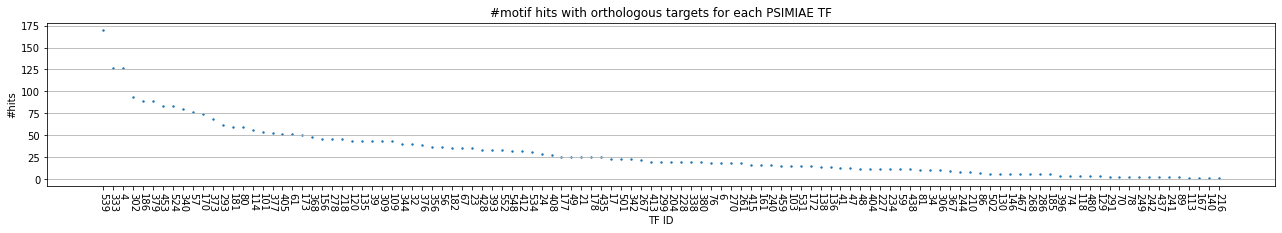

In [26]:
fig, ax = plt.subplots(figsize=(22,3))
counts = df_fimo_hits_w_orthos['tf_id'].value_counts().sort_values(ascending=False)
y = counts.values
x_labels = counts.index.values
x = range(len(x_labels))
plt.scatter(x,y, s=2,)
plt.xlabel('TF ID')
plt.ylabel('#hits')
plt.grid(True, axis='y')
plt.xticks(x, x_labels, rotation = -90) 
plt.title(f"#motif hits with orthologous targets for each {DAP_SPECIES} TF")

Text(0.5, 1.0, '#motif hits with orthologous targets for each PSIMIAE TF')

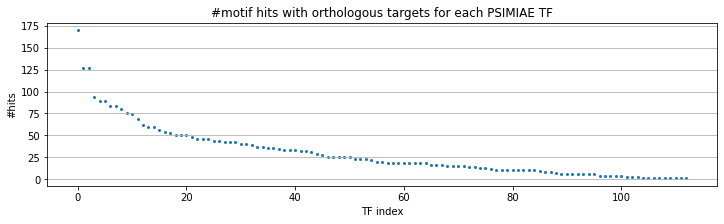

In [27]:
fig, ax = plt.subplots(figsize=(12,3))
counts = df_fimo_hits_w_orthos['tf_id'].value_counts().sort_values(ascending=False)
y = counts.values
x = range(len(y))
plt.scatter(x, y, s=4)
plt.grid(True, axis='y')
plt.xlabel('TF index')
plt.ylabel('#hits')
plt.title(f"#motif hits with orthologous targets for each {DAP_SPECIES} TF")